In [0]:
import matplotlib.pyplot as plt
import numpy as np
#!pip3 install tqdm
#!pip3 install --no-cache-dir -I pillow
from tqdm import tqdm

%matplotlib inline

In [0]:
#!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
#!pip3 install torchvision

import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (30,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3627511500979677948, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 348782592
 locality {
   bus_id: 1
 }
 incarnation: 7389688999452544654
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

#  Read db and apply data augmentation

In [0]:
#!git clone https://github.com/fgvenegas/Deep-Learning-Pokemon-Image-Generator.git

In [0]:
dataset = dset.ImageFolder(root="Deep-Learning-Pokemon-Image-Generator/root/",
       transform=transforms.Compose([
       transforms.Resize(size=[64,64]),
       transforms.RandomHorizontalFlip(),
       transforms.ColorJitter(brightness=0.1, contrast=1.1),
       transforms.RandomVerticalFlip(),
       transforms.RandomRotation(degrees=[0.2, 0.8]),
       transforms.ToTensor(),
]))

In [0]:
#image = tf.image.random_flip_left_right(image)
#image = tf.image.random_brightness(image, max_delta = 0.1)
#image = tf.image.random_contrast(image, lower = 0.9, upper = 1.1)

In [0]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                         shuffle=True, num_workers=int(2))

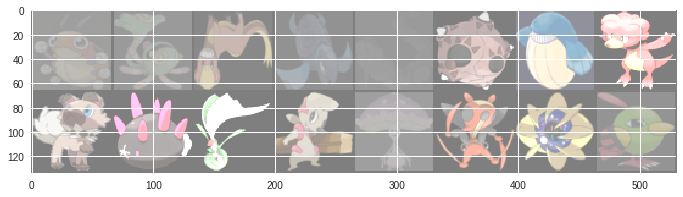

In [12]:
# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [13]:
for i, data in enumerate(dataloader, 0):
    test, _ = data
    print(test.shape, len(dataloader))
    break


torch.Size([16, 3, 64, 64]) 51


# Gan Model

In [0]:
nc = 3   # n_channels = 3, color image.
ndf = 128 # n_filters disc
ngf = 128 # n_filters gen
nz = 100 # z dimension
batch_size = 128


### Discriminator

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [0]:
class Discriminator(nn.Module):
  
  def __init__(self):
    super(Discriminator, self).__init__()
    self.ngpu = 1
    self.main = nn.Sequential(
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
        #                 padding=0, dilation=1, groups=1, bias=True)
        # Bias False It is because BN eliminates the bias (why?), and BN 
        # (with affine=True) adds a bias so it’s equivalent.
        # Input Size nc x 64 x 64
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True), #inplace doesn't accumulate memory
        # First layer not apply BN
        # Size ndf x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # Size ndf*2 x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # Size ndf*4 x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        ## Size ndf*8 x 8 x 8
        ## nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
        ## nn.BatchNorm2d(ndf * 16),
        ## nn.LeakyReLU(0.2, inplace=True),
        # Size ndf * 8 x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    
    )
    
  def forward(self, x):
      return self.main(x).view(-1, 1).squeeze(1)
    
    

In [0]:
D = Discriminator()

In [18]:
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d (3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d (256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d (1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [19]:
''' Testing discriminator
for i, data in enumerate(dataloader, 0):
    test, _ = data
print(test.shape)
D.forward(Variable(test))
'''

' Testing discriminator\nfor i, data in enumerate(dataloader, 0):\n    test, _ = data\nprint(test.shape)\nD.forward(Variable(test))\n'

### Generator

In [0]:
class Generator(nn.Module):
  
  def __init__(self):
    super(Generator, self).__init__()
    self.ngpu=1
    self.main = nn.Sequential(
        # Deconvolution layer is a very unfortunate name and should rather
        # be called a transposed convolutional layer.
        # https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
        ##nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
        ##nn.BatchNorm2d(ngf * 16),
        ##nn.ReLU(True),
        ## Size ngf * 8 x 4 x 4
        
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # Size ngf * 8 x 4 x 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # Size ngf * 4 x 8 x 8
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # Size ngf * 2 x 16 x 16
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # Size ngf x 32 x 32
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # Size nc x 64 x 64
    )
    
  def forward(self, x):
    return self.main(x)

In [0]:
G = Generator()

In [23]:
print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d (100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Setup

In [0]:
criterion = nn.BCELoss() # I'll always compare the answer of the discriminator
                         # with the Discrimintor using real and fake data and 
                         # with the Generator using only the fake data

In [0]:
input = torch.FloatTensor(batch_size, 3, 128, 128)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
#fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1) # For test generation
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [0]:
# CUDA
use_cuda = True

if use_cuda and torch.cuda.is_available():
  D.cuda()
  G.cuda()
  criterion.cuda()
  input, label = input.cuda(), label.cuda()
  noise = noise.cuda()

In [0]:
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
n_epochs = 30

In [31]:
for epoch in range(n_epochs):
   for i, data in enumerate(dataloader, 0):
      # Discriminator update: max log(D(x)) + log(1 - D(G(z)))
      ## Real training 
      D.zero_grad()
      real, _ = data
      bs = real.size(0)
      if use_cuda and torch.cuda.is_available():
        real = real.cuda()
      input.resize_as_(real).copy_(real)
      label.resize_(bs).fill_(real_label)
      inputv = Variable(input)
      labelv = Variable(label)
      
      output = D(inputv)
      loss_r = criterion(output, labelv)
      loss_r.backward()
      
      ## Fake training
      noise.resize_(bs, nz, 1, 1).normal_(0, 1)
      noisev = Variable(noise)
      fake = G(noisev)
      labelv = Variable(label.fill_(fake_label))
      output = D(fake.detach())
      # The computation of gradients wrt the weights of G can be fully
      # avoided in the backward pass if the graph is detached where it is.
      loss_f = criterion(output, labelv)
      loss_f.backward()
      
      loss_d = loss_r + loss_f
      optimizerD.step()
      
      # Generator update max log(D(G(z)))
      G.zero_grad()
      labelv = Variable(label.fill_(real_label))
      output = D(fake)
      loss_g = criterion(output, labelv)
      loss_g.backward()
      optimizerG.step()
      
      print("batch size", bs)
      print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' 
              % (epoch + 1, n_epochs, i + 1, len(dataloader), loss_d, loss_g))

batch size 16
[1/30][1/51] Loss_D: 1.3548 Loss_G: 4.7911
batch size 16
[1/30][2/51] Loss_D: 1.2831 Loss_G: 5.6387
batch size 16
[1/30][3/51] Loss_D: 0.8300 Loss_G: 5.0867
batch size 16
[1/30][4/51] Loss_D: 2.2427 Loss_G: 7.0065
batch size 16
[1/30][5/51] Loss_D: 0.7481 Loss_G: 5.1156
batch size 16
[1/30][6/51] Loss_D: 1.7536 Loss_G: 7.8842
batch size 16
[1/30][7/51] Loss_D: 0.8641 Loss_G: 5.9583
batch size 16
[1/30][8/51] Loss_D: 1.4228 Loss_G: 7.6446
batch size 16
[1/30][9/51] Loss_D: 0.4548 Loss_G: 6.9896
batch size 16
[1/30][10/51] Loss_D: 0.9531 Loss_G: 6.9455
batch size 16
[1/30][11/51] Loss_D: 0.6087 Loss_G: 6.0484
batch size 16
[1/30][12/51] Loss_D: 2.6008 Loss_G: 8.8391
batch size 16
[1/30][13/51] Loss_D: 1.7447 Loss_G: 7.8607
batch size 16
[1/30][14/51] Loss_D: 0.5957 Loss_G: 4.7369
batch size 16
[1/30][15/51] Loss_D: 3.4940 Loss_G: 6.0927
batch size 16
[1/30][16/51] Loss_D: 0.4619 Loss_G: 5.7160
batch size 16
[1/30][17/51] Loss_D: 0.6324 Loss_G: 4.0407
batch size 16
[1/30][18

batch size 16
[2/30][24/51] Loss_D: 0.7971 Loss_G: 3.5712
batch size 16
[2/30][25/51] Loss_D: 0.4857 Loss_G: 3.3248
batch size 16
[2/30][26/51] Loss_D: 0.4066 Loss_G: 2.5737
batch size 16
[2/30][27/51] Loss_D: 0.4375 Loss_G: 2.5270
batch size 16
[2/30][28/51] Loss_D: 0.2849 Loss_G: 2.9061
batch size 16
[2/30][29/51] Loss_D: 0.2675 Loss_G: 2.9738
batch size 16
[2/30][30/51] Loss_D: 0.1976 Loss_G: 3.3068
batch size 16
[2/30][31/51] Loss_D: 0.2513 Loss_G: 3.2951
batch size 16
[2/30][32/51] Loss_D: 0.1968 Loss_G: 3.5506
batch size 16
[2/30][33/51] Loss_D: 0.4016 Loss_G: 3.5787
batch size 16
[2/30][34/51] Loss_D: 0.4807 Loss_G: 2.5900
batch size 16
[2/30][35/51] Loss_D: 1.1781 Loss_G: 3.4678
batch size 16
[2/30][36/51] Loss_D: 0.8861 Loss_G: 2.5045
batch size 16
[2/30][37/51] Loss_D: 0.4056 Loss_G: 2.4091
batch size 16
[2/30][38/51] Loss_D: 0.4684 Loss_G: 3.3078
batch size 16
[2/30][39/51] Loss_D: 0.3445 Loss_G: 3.3692
batch size 16
[2/30][40/51] Loss_D: 0.3052 Loss_G: 3.3023
batch size 16


batch size 16
[3/30][45/51] Loss_D: 0.1658 Loss_G: 3.4948
batch size 16
[3/30][46/51] Loss_D: 0.5615 Loss_G: 4.5553
batch size 16
[3/30][47/51] Loss_D: 0.4621 Loss_G: 3.4672
batch size 16
[3/30][48/51] Loss_D: 0.5132 Loss_G: 3.1587
batch size 16
[3/30][49/51] Loss_D: 0.6284 Loss_G: 5.0639
batch size 16
[3/30][50/51] Loss_D: 0.3369 Loss_G: 4.7098
batch size 7
[3/30][51/51] Loss_D: 0.2291 Loss_G: 3.7100
batch size 16
[4/30][1/51] Loss_D: 0.1755 Loss_G: 3.5193
batch size 16
[4/30][2/51] Loss_D: 0.1589 Loss_G: 3.5489
batch size 16
[4/30][3/51] Loss_D: 0.2901 Loss_G: 4.3611
batch size 16
[4/30][4/51] Loss_D: 0.1886 Loss_G: 4.2257
batch size 16
[4/30][5/51] Loss_D: 0.3737 Loss_G: 2.5449
batch size 16
[4/30][6/51] Loss_D: 0.5215 Loss_G: 5.6567
batch size 16
[4/30][7/51] Loss_D: 0.3326 Loss_G: 4.7850
batch size 16
[4/30][8/51] Loss_D: 0.2829 Loss_G: 3.8326
batch size 16
[4/30][9/51] Loss_D: 0.3168 Loss_G: 5.4628
batch size 16
[4/30][10/51] Loss_D: 0.0868 Loss_G: 5.3027
batch size 16
[4/30][11/


[5/30][14/51] Loss_D: 0.4744 Loss_G: 7.3401
batch size 16
[5/30][15/51] Loss_D: 0.2115 Loss_G: 7.2048
batch size 16
[5/30][16/51] Loss_D: 0.1667 Loss_G: 5.0331
batch size 16
[5/30][17/51] Loss_D: 0.2943 Loss_G: 6.4620
batch size 16
[5/30][18/51] Loss_D: 0.3850 Loss_G: 7.6690
batch size 16
[5/30][19/51] Loss_D: 0.6075 Loss_G: 4.4402
batch size 16
[5/30][20/51] Loss_D: 0.4246 Loss_G: 6.0998
batch size 16
[5/30][21/51] Loss_D: 0.2831 Loss_G: 4.6133
batch size 16
[5/30][22/51] Loss_D: 0.1868 Loss_G: 5.2116
batch size 16
[5/30][23/51] Loss_D: 0.1962 Loss_G: 6.8265
batch size 16
[5/30][24/51] Loss_D: 0.0969 Loss_G: 6.0823
batch size 16
[5/30][25/51] Loss_D: 0.2869 Loss_G: 3.0872
batch size 16
[5/30][26/51] Loss_D: 0.7868 Loss_G: 8.4126
batch size 16
[5/30][27/51] Loss_D: 0.4754 Loss_G: 6.6588
batch size 16
[5/30][28/51] Loss_D: 0.1759 Loss_G: 4.1811
batch size 16
[5/30][29/51] Loss_D: 0.6020 Loss_G: 6.2885
batch size 16
[5/30][30/51] Loss_D: 0.0622 Loss_G: 6.4378
batch size 16
[5/30][31/51]

[6/30][35/51] Loss_D: 0.4600 Loss_G: 2.4767
batch size 16
[6/30][36/51] Loss_D: 0.5526 Loss_G: 1.8077
batch size 16
[6/30][37/51] Loss_D: 0.5976 Loss_G: 3.0358
batch size 16
[6/30][38/51] Loss_D: 0.5792 Loss_G: 2.0693
batch size 16
[6/30][39/51] Loss_D: 0.9146 Loss_G: 3.1174
batch size 16
[6/30][40/51] Loss_D: 0.4875 Loss_G: 2.5322
batch size 16
[6/30][41/51] Loss_D: 0.7722 Loss_G: 1.2226
batch size 16
[6/30][42/51] Loss_D: 0.3377 Loss_G: 2.3121
batch size 16
[6/30][43/51] Loss_D: 0.7012 Loss_G: 3.2797
batch size 16
[6/30][44/51] Loss_D: 0.3307 Loss_G: 2.8696
batch size 16
[6/30][45/51] Loss_D: 0.3192 Loss_G: 2.3166
batch size 16
[6/30][46/51] Loss_D: 0.4816 Loss_G: 2.1426
batch size 16
[6/30][47/51] Loss_D: 0.4743 Loss_G: 2.2693
batch size 16
[6/30][48/51] Loss_D: 0.6326 Loss_G: 2.7984
batch size 16
[6/30][49/51] Loss_D: 1.0218 Loss_G: 3.1574
batch size 16
[6/30][50/51] Loss_D: 0.7916 Loss_G: 1.3047
batch size 7
[6/30][51/51] Loss_D: 1.3226 Loss_G: 7.0809
batch size 16
[7/30][1/51] Lo

batch size 16
[8/30][4/51] Loss_D: 0.7658 Loss_G: 3.9848
batch size 16
[8/30][5/51] Loss_D: 0.7814 Loss_G: 2.0739
batch size 16
[8/30][6/51] Loss_D: 1.3446 Loss_G: 3.4787
batch size 16
[8/30][7/51] Loss_D: 0.4704 Loss_G: 3.1909
batch size 16
[8/30][8/51] Loss_D: 0.8353 Loss_G: 1.8843
batch size 16
[8/30][9/51] Loss_D: 0.8982 Loss_G: 4.6260
batch size 16
[8/30][10/51] Loss_D: 1.0213 Loss_G: 1.9317
batch size 16
[8/30][11/51] Loss_D: 1.0244 Loss_G: 2.5674
batch size 16
[8/30][12/51] Loss_D: 0.5141 Loss_G: 3.7749
batch size 16
[8/30][13/51] Loss_D: 0.6616 Loss_G: 2.2154
batch size 16
[8/30][14/51] Loss_D: 0.6263 Loss_G: 2.9198
batch size 16
[8/30][15/51] Loss_D: 0.7057 Loss_G: 4.0228
batch size 16
[8/30][16/51] Loss_D: 0.5644 Loss_G: 2.4153
batch size 16
[8/30][17/51] Loss_D: 1.0438 Loss_G: 5.2077
batch size 16
[8/30][18/51] Loss_D: 0.8474 Loss_G: 2.7635
batch size 16
[8/30][19/51] Loss_D: 0.5501 Loss_G: 1.3509
batch size 16
[8/30][20/51] Loss_D: 1.7212 Loss_G: 3.6008
batch size 16
[8/30]

[9/30][26/51] Loss_D: 1.3638 Loss_G: 7.8084
batch size 16
[9/30][27/51] Loss_D: 2.5165 Loss_G: 4.9484
batch size 16
[9/30][28/51] Loss_D: 0.2929 Loss_G: 1.9864
batch size 16
[9/30][29/51] Loss_D: 0.2961 Loss_G: 2.7332
batch size 16
[9/30][30/51] Loss_D: 1.1401 Loss_G: 5.9371
batch size 16
[9/30][31/51] Loss_D: 0.3604 Loss_G: 5.2913
batch size 16
[9/30][32/51] Loss_D: 0.4049 Loss_G: 2.3922
batch size 16
[9/30][33/51] Loss_D: 0.4258 Loss_G: 4.9585
batch size 16
[9/30][34/51] Loss_D: 0.1708 Loss_G: 5.1485
batch size 16
[9/30][35/51] Loss_D: 0.2702 Loss_G: 4.2107
batch size 16
[9/30][36/51] Loss_D: 0.2439 Loss_G: 3.3687
batch size 16
[9/30][37/51] Loss_D: 0.6772 Loss_G: 5.6407
batch size 16
[9/30][38/51] Loss_D: 0.6888 Loss_G: 4.0634
batch size 16
[9/30][39/51] Loss_D: 0.4977 Loss_G: 2.4866
batch size 16
[9/30][40/51] Loss_D: 1.2535 Loss_G: 6.4777
batch size 16
[9/30][41/51] Loss_D: 0.4759 Loss_G: 5.3956
batch size 16
[9/30][42/51] Loss_D: 0.9432 Loss_G: 2.1887
batch size 16
[9/30][43/51] 

batch size 16
[10/30][48/51] Loss_D: 1.2560 Loss_G: 3.6839
batch size 16
[10/30][49/51] Loss_D: 0.3800 Loss_G: 2.3023
batch size 16
[10/30][50/51] Loss_D: 0.5123 Loss_G: 3.5973
batch size 7
[10/30][51/51] Loss_D: 0.5712 Loss_G: 3.1697
batch size 16
[11/30][1/51] Loss_D: 1.1381 Loss_G: 2.5083
batch size 16
[11/30][2/51] Loss_D: 0.6378 Loss_G: 3.3416
batch size 16
[11/30][3/51] Loss_D: 0.4838 Loss_G: 2.8701
batch size 16
[11/30][4/51] Loss_D: 0.5147 Loss_G: 3.7633
batch size 16
[11/30][5/51] Loss_D: 1.0794 Loss_G: 2.5798
batch size 16
[11/30][6/51] Loss_D: 0.6441 Loss_G: 3.6505
batch size 16
[11/30][7/51] Loss_D: 0.6293 Loss_G: 2.3775
batch size 16
[11/30][8/51] Loss_D: 0.5106 Loss_G: 3.0574
batch size 16
[11/30][9/51] Loss_D: 0.6053 Loss_G: 4.6244
batch size 16
[11/30][10/51] Loss_D: 1.3723 Loss_G: 1.4233
batch size 16
[11/30][11/51] Loss_D: 1.5962 Loss_G: 5.3273
batch size 16
[11/30][12/51] Loss_D: 0.6024 Loss_G: 3.8074
batch size 16
[11/30][13/51] Loss_D: 0.9348 Loss_G: 1.2037
batch s

batch size 16
[12/30][18/51] Loss_D: 0.2072 Loss_G: 5.6791
batch size 16
[12/30][19/51] Loss_D: 0.8036 Loss_G: 1.7184
batch size 16
[12/30][20/51] Loss_D: 1.4723 Loss_G: 5.9783
batch size 16
[12/30][21/51] Loss_D: 1.3845 Loss_G: 2.2799
batch size 16
[12/30][22/51] Loss_D: 0.4414 Loss_G: 2.5988
batch size 16
[12/30][23/51] Loss_D: 0.5514 Loss_G: 4.0153
batch size 16
[12/30][24/51] Loss_D: 0.7367 Loss_G: 3.0298
batch size 16
[12/30][25/51] Loss_D: 0.4937 Loss_G: 3.9693
batch size 16
[12/30][26/51] Loss_D: 0.9862 Loss_G: 1.8938
batch size 16
[12/30][27/51] Loss_D: 0.3768 Loss_G: 3.1016
batch size 16
[12/30][28/51] Loss_D: 0.8175 Loss_G: 3.7086
batch size 16
[12/30][29/51] Loss_D: 0.5168 Loss_G: 3.4799
batch size 16
[12/30][30/51] Loss_D: 1.0520 Loss_G: 1.3678
batch size 16
[12/30][31/51] Loss_D: 1.4269 Loss_G: 6.3827
batch size 16
[12/30][32/51] Loss_D: 1.2184 Loss_G: 2.7896
batch size 16
[12/30][33/51] Loss_D: 0.5186 Loss_G: 2.1783
batch size 16
[12/30][34/51] Loss_D: 0.8322 Loss_G: 4.57


[13/30][41/51] Loss_D: 1.0119 Loss_G: 5.1722
batch size 16
[13/30][42/51] Loss_D: 0.9643 Loss_G: 2.1986
batch size 16
[13/30][43/51] Loss_D: 1.0373 Loss_G: 5.2292
batch size 16
[13/30][44/51] Loss_D: 0.6743 Loss_G: 3.6780
batch size 16
[13/30][45/51] Loss_D: 0.6284 Loss_G: 2.4025
batch size 16
[13/30][46/51] Loss_D: 0.6626 Loss_G: 3.9795
batch size 16
[13/30][47/51] Loss_D: 0.4341 Loss_G: 3.3854
batch size 16
[13/30][48/51] Loss_D: 0.4626 Loss_G: 2.5067
batch size 16
[13/30][49/51] Loss_D: 0.3341 Loss_G: 3.2491
batch size 16
[13/30][50/51] Loss_D: 0.7366 Loss_G: 5.5428
batch size 7
[13/30][51/51] Loss_D: 0.2412 Loss_G: 5.7629
batch size 16
[14/30][1/51] Loss_D: 0.5145 Loss_G: 2.8294
batch size 16
[14/30][2/51] Loss_D: 0.7603 Loss_G: 2.3900
batch size 16
[14/30][3/51] Loss_D: 1.4403 Loss_G: 7.6638
batch size 16
[14/30][4/51] Loss_D: 1.6156 Loss_G: 4.0121
batch size 16
[14/30][5/51] Loss_D: 0.9524 Loss_G: 1.3967
batch size 16
[14/30][6/51] Loss_D: 0.5821 Loss_G: 2.3980
batch size 16
[14


[15/30][10/51] Loss_D: 1.2410 Loss_G: 3.1517
batch size 16
[15/30][11/51] Loss_D: 0.7786 Loss_G: 4.1063
batch size 16
[15/30][12/51] Loss_D: 0.3659 Loss_G: 4.0822
batch size 16
[15/30][13/51] Loss_D: 0.5346 Loss_G: 3.1493
batch size 16
[15/30][14/51] Loss_D: 0.8397 Loss_G: 3.0449
batch size 16
[15/30][15/51] Loss_D: 0.7078 Loss_G: 2.7369
batch size 16
[15/30][16/51] Loss_D: 0.5869 Loss_G: 3.7607
batch size 16
[15/30][17/51] Loss_D: 0.6998 Loss_G: 5.8212
batch size 16
[15/30][18/51] Loss_D: 1.5974 Loss_G: 1.2768
batch size 16
[15/30][19/51] Loss_D: 1.5807 Loss_G: 4.4775
batch size 16
[15/30][20/51] Loss_D: 0.5149 Loss_G: 3.8610
batch size 16
[15/30][21/51] Loss_D: 0.5284 Loss_G: 2.5636
batch size 16
[15/30][22/51] Loss_D: 0.4925 Loss_G: 2.9286
batch size 16
[15/30][23/51] Loss_D: 0.3884 Loss_G: 3.1503
batch size 16
[15/30][24/51] Loss_D: 0.3877 Loss_G: 3.6695
batch size 16
[15/30][25/51] Loss_D: 0.4694 Loss_G: 2.6679
batch size 16
[15/30][26/51] Loss_D: 0.7105 Loss_G: 5.1038
batch size

batch size 16
[16/30][31/51] Loss_D: 0.5109 Loss_G: 2.3613
batch size 16
[16/30][32/51] Loss_D: 1.1227 Loss_G: 4.6820
batch size 16
[16/30][33/51] Loss_D: 0.6838 Loss_G: 3.6343
batch size 16
[16/30][34/51] Loss_D: 0.6344 Loss_G: 2.0551
batch size 16
[16/30][35/51] Loss_D: 1.2780 Loss_G: 4.2762
batch size 16
[16/30][36/51] Loss_D: 0.4205 Loss_G: 4.2965
batch size 16
[16/30][37/51] Loss_D: 0.8009 Loss_G: 2.0018
batch size 16
[16/30][38/51] Loss_D: 0.2972 Loss_G: 2.7253
batch size 16
[16/30][39/51] Loss_D: 0.9876 Loss_G: 5.0786
batch size 16
[16/30][40/51] Loss_D: 0.4707 Loss_G: 4.8834
batch size 16
[16/30][41/51] Loss_D: 0.3165 Loss_G: 2.6991
batch size 16
[16/30][42/51] Loss_D: 0.5510 Loss_G: 3.9343
batch size 16
[16/30][43/51] Loss_D: 0.5792 Loss_G: 2.9402
batch size 16
[16/30][44/51] Loss_D: 0.4375 Loss_G: 3.5474
batch size 16
[16/30][45/51] Loss_D: 0.9186 Loss_G: 1.8960
batch size 16
[16/30][46/51] Loss_D: 0.9857 Loss_G: 6.0614
batch size 16
[16/30][47/51] Loss_D: 0.2593 Loss_G: 5.67

batch size 7
[17/30][51/51] Loss_D: 0.2963 Loss_G: 5.5168
batch size 16
[18/30][1/51] Loss_D: 1.2198 Loss_G: 0.3412
batch size 16
[18/30][2/51] Loss_D: 0.8279 Loss_G: 8.1551
batch size 16
[18/30][3/51] Loss_D: 0.3700 Loss_G: 5.0344
batch size 16
[18/30][4/51] Loss_D: 0.2131 Loss_G: 4.5703
batch size 16
[18/30][5/51] Loss_D: 0.8488 Loss_G: 5.5201
batch size 16
[18/30][6/51] Loss_D: 0.6775 Loss_G: 3.9998
batch size 16
[18/30][7/51] Loss_D: 0.7422 Loss_G: 2.6026
batch size 16
[18/30][8/51] Loss_D: 0.7146 Loss_G: 5.7320
batch size 16
[18/30][9/51] Loss_D: 0.5654 Loss_G: 4.4288
batch size 16
[18/30][10/51] Loss_D: 0.2978 Loss_G: 3.1797
batch size 16
[18/30][11/51] Loss_D: 0.5120 Loss_G: 3.9302
batch size 16
[18/30][12/51] Loss_D: 0.3318 Loss_G: 4.1611
batch size 16
[18/30][13/51] Loss_D: 0.6367 Loss_G: 4.5582
batch size 16
[18/30][14/51] Loss_D: 1.1552 Loss_G: 0.6399
batch size 16
[18/30][15/51] Loss_D: 1.1283 Loss_G: 5.1991
batch size 16
[18/30][16/51] Loss_D: 0.2078 Loss_G: 4.7213
batch s


[19/30][19/51] Loss_D: 0.5971 Loss_G: 3.1891
batch size 16
[19/30][20/51] Loss_D: 0.7385 Loss_G: 6.4910
batch size 16
[19/30][21/51] Loss_D: 1.0177 Loss_G: 1.5707
batch size 16
[19/30][22/51] Loss_D: 1.0395 Loss_G: 7.3519
batch size 16
[19/30][23/51] Loss_D: 0.8694 Loss_G: 2.2636
batch size 16
[19/30][24/51] Loss_D: 0.9183 Loss_G: 2.4932
batch size 16
[19/30][25/51] Loss_D: 0.7503 Loss_G: 5.8113
batch size 16
[19/30][26/51] Loss_D: 1.3553 Loss_G: 1.6914
batch size 16
[19/30][27/51] Loss_D: 1.1278 Loss_G: 6.7812
batch size 16
[19/30][28/51] Loss_D: 1.1062 Loss_G: 3.3712
batch size 16
[19/30][29/51] Loss_D: 0.5608 Loss_G: 3.9274
batch size 16
[19/30][30/51] Loss_D: 0.6600 Loss_G: 7.1361
batch size 16
[19/30][31/51] Loss_D: 1.4001 Loss_G: 2.5529
batch size 16
[19/30][32/51] Loss_D: 0.8754 Loss_G: 4.9509
batch size 16
[19/30][33/51] Loss_D: 0.8206 Loss_G: 2.1989
batch size 16
[19/30][34/51] Loss_D: 0.8570 Loss_G: 3.9813
batch size 16
[19/30][35/51] Loss_D: 0.5213 Loss_G: 4.1977
batch size

batch size 16
[20/30][40/51] Loss_D: 0.9557 Loss_G: 7.5309
batch size 16
[20/30][41/51] Loss_D: 0.2916 Loss_G: 6.0027
batch size 16
[20/30][42/51] Loss_D: 0.4347 Loss_G: 3.5466
batch size 16
[20/30][43/51] Loss_D: 0.6467 Loss_G: 5.6745
batch size 16
[20/30][44/51] Loss_D: 0.4199 Loss_G: 4.2996
batch size 16
[20/30][45/51] Loss_D: 0.6719 Loss_G: 2.3994
batch size 16
[20/30][46/51] Loss_D: 0.9454 Loss_G: 6.7774
batch size 16
[20/30][47/51] Loss_D: 0.6953 Loss_G: 2.7856
batch size 16
[20/30][48/51] Loss_D: 0.5456 Loss_G: 4.6464
batch size 16
[20/30][49/51] Loss_D: 0.4280 Loss_G: 3.6978
batch size 16
[20/30][50/51] Loss_D: 0.5490 Loss_G: 5.4379
batch size 7
[20/30][51/51] Loss_D: 0.7249 Loss_G: 1.7020
batch size 16
[21/30][1/51] Loss_D: 0.9709 Loss_G: 5.2135
batch size 16
[21/30][2/51] Loss_D: 1.1004 Loss_G: 2.0455
batch size 16
[21/30][3/51] Loss_D: 0.6970 Loss_G: 3.6489
batch size 16
[21/30][4/51] Loss_D: 0.4664 Loss_G: 5.2641
batch size 16
[21/30][5/51] Loss_D: 0.4180 Loss_G: 3.9062
bat

[22/30][10/51] Loss_D: 0.7028 Loss_G: 1.7846
batch size 16
[22/30][11/51] Loss_D: 0.6828 Loss_G: 3.1342
batch size 16
[22/30][12/51] Loss_D: 0.6525 Loss_G: 4.6984
batch size 16
[22/30][13/51] Loss_D: 0.3396 Loss_G: 3.8694
batch size 16
[22/30][14/51] Loss_D: 0.6785 Loss_G: 1.6577
batch size 16
[22/30][15/51] Loss_D: 1.0630 Loss_G: 5.8550
batch size 16
[22/30][16/51] Loss_D: 0.5190 Loss_G: 5.1050
batch size 16
[22/30][17/51] Loss_D: 0.2192 Loss_G: 3.1108
batch size 16
[22/30][18/51] Loss_D: 0.5463 Loss_G: 3.6151
batch size 16
[22/30][19/51] Loss_D: 0.5835 Loss_G: 2.6677
batch size 16
[22/30][20/51] Loss_D: 0.4383 Loss_G: 3.9789
batch size 16
[22/30][21/51] Loss_D: 0.4471 Loss_G: 2.9020
batch size 16
[22/30][22/51] Loss_D: 0.5556 Loss_G: 3.3514
batch size 16
[22/30][23/51] Loss_D: 0.7763 Loss_G: 0.9336
batch size 16
[22/30][24/51] Loss_D: 1.7030 Loss_G: 7.5917
batch size 16
[22/30][25/51] Loss_D: 1.5540 Loss_G: 3.2451
batch size 16
[22/30][26/51] Loss_D: 0.6406 Loss_G: 0.9374
batch size 


[23/30][30/51] Loss_D: 0.3616 Loss_G: 6.0132
batch size 16
[23/30][31/51] Loss_D: 0.4892 Loss_G: 2.8571
batch size 16
[23/30][32/51] Loss_D: 0.8324 Loss_G: 1.1849
batch size 16
[23/30][33/51] Loss_D: 1.8996 Loss_G: 9.3907
batch size 16
[23/30][34/51] Loss_D: 2.0281 Loss_G: 3.7859
batch size 16
[23/30][35/51] Loss_D: 0.6818 Loss_G: 0.7238
batch size 16
[23/30][36/51] Loss_D: 2.0431 Loss_G: 4.6707
batch size 16
[23/30][37/51] Loss_D: 0.8170 Loss_G: 4.2352
batch size 16
[23/30][38/51] Loss_D: 0.4322 Loss_G: 3.7190
batch size 16
[23/30][39/51] Loss_D: 0.7770 Loss_G: 1.6160
batch size 16
[23/30][40/51] Loss_D: 0.8145 Loss_G: 3.6899
batch size 16
[23/30][41/51] Loss_D: 0.6929 Loss_G: 4.6188
batch size 16
[23/30][42/51] Loss_D: 0.5421 Loss_G: 3.4066
batch size 16
[23/30][43/51] Loss_D: 0.5802 Loss_G: 2.5790
batch size 16
[23/30][44/51] Loss_D: 0.4968 Loss_G: 4.7544
batch size 16
[23/30][45/51] Loss_D: 0.2358 Loss_G: 4.5258
batch size 16
[23/30][46/51] Loss_D: 0.4458 Loss_G: 2.7222
batch size

batch size 16
[24/30][50/51] Loss_D: 0.2909 Loss_G: 3.4032
batch size 7
[24/30][51/51] Loss_D: 0.6493 Loss_G: 5.0824
batch size 16
[25/30][1/51] Loss_D: 0.9507 Loss_G: 1.6687
batch size 16
[25/30][2/51] Loss_D: 0.9927 Loss_G: 4.0232
batch size 16
[25/30][3/51] Loss_D: 0.5415 Loss_G: 3.6920
batch size 16
[25/30][4/51] Loss_D: 0.4253 Loss_G: 2.4513
batch size 16
[25/30][5/51] Loss_D: 0.7862 Loss_G: 5.8579
batch size 16
[25/30][6/51] Loss_D: 0.4827 Loss_G: 4.0549
batch size 16
[25/30][7/51] Loss_D: 0.4074 Loss_G: 2.3274
batch size 16
[25/30][8/51] Loss_D: 1.1782 Loss_G: 6.3965
batch size 16
[25/30][9/51] Loss_D: 1.6385 Loss_G: 1.0858
batch size 16
[25/30][10/51] Loss_D: 1.3217 Loss_G: 4.8268
batch size 16
[25/30][11/51] Loss_D: 0.1674 Loss_G: 5.4613
batch size 16
[25/30][12/51] Loss_D: 0.9774 Loss_G: 2.2515
batch size 16
[25/30][13/51] Loss_D: 0.6783 Loss_G: 2.9445
batch size 16
[25/30][14/51] Loss_D: 0.5590 Loss_G: 4.6163
batch size 16
[25/30][15/51] Loss_D: 0.5583 Loss_G: 3.3334
batch s

batch size 16
[26/30][20/51] Loss_D: 0.5746 Loss_G: 3.9590
batch size 16
[26/30][21/51] Loss_D: 0.4419 Loss_G: 4.2010
batch size 16
[26/30][22/51] Loss_D: 0.4139 Loss_G: 3.0300
batch size 16
[26/30][23/51] Loss_D: 0.6651 Loss_G: 3.5521
batch size 16
[26/30][24/51] Loss_D: 0.8865 Loss_G: 1.3684
batch size 16
[26/30][25/51] Loss_D: 1.5689 Loss_G: 7.8760
batch size 16
[26/30][26/51] Loss_D: 0.8671 Loss_G: 4.7263
batch size 16
[26/30][27/51] Loss_D: 0.6600 Loss_G: 1.0657
batch size 16
[26/30][28/51] Loss_D: 1.4150 Loss_G: 5.3945
batch size 16
[26/30][29/51] Loss_D: 0.2758 Loss_G: 5.9189
batch size 16
[26/30][30/51] Loss_D: 0.2523 Loss_G: 4.8304
batch size 16
[26/30][31/51] Loss_D: 0.3851 Loss_G: 2.2522
batch size 16
[26/30][32/51] Loss_D: 0.5816 Loss_G: 3.8641
batch size 16
[26/30][33/51] Loss_D: 0.3493 Loss_G: 3.6762
batch size 16
[26/30][34/51] Loss_D: 0.4396 Loss_G: 2.8710
batch size 16
[26/30][35/51] Loss_D: 0.4945 Loss_G: 4.1155
batch size 16
[26/30][36/51] Loss_D: 0.6444 Loss_G: 2.76

batch size 16
[27/30][40/51] Loss_D: 0.7324 Loss_G: 5.5921
batch size 16
[27/30][41/51] Loss_D: 0.1747 Loss_G: 6.1982
batch size 16
[27/30][42/51] Loss_D: 0.2229 Loss_G: 4.2908
batch size 16
[27/30][43/51] Loss_D: 0.4947 Loss_G: 2.4345
batch size 16
[27/30][44/51] Loss_D: 0.9703 Loss_G: 5.5731
batch size 16
[27/30][45/51] Loss_D: 0.5961 Loss_G: 3.0623
batch size 16
[27/30][46/51] Loss_D: 0.4131 Loss_G: 2.3352
batch size 16
[27/30][47/51] Loss_D: 0.5627 Loss_G: 4.9019
batch size 16
[27/30][48/51] Loss_D: 0.5071 Loss_G: 3.8549
batch size 16
[27/30][49/51] Loss_D: 0.4735 Loss_G: 2.2800
batch size 16
[27/30][50/51] Loss_D: 0.4567 Loss_G: 3.8625
batch size 7
[27/30][51/51] Loss_D: 0.7147 Loss_G: 5.7734
batch size 16
[28/30][1/51] Loss_D: 0.9999 Loss_G: 1.5347
batch size 16
[28/30][2/51] Loss_D: 1.8072 Loss_G: 9.3525
batch size 16
[28/30][3/51] Loss_D: 1.1610 Loss_G: 4.4467
batch size 16
[28/30][4/51] Loss_D: 0.1551 Loss_G: 2.7241
batch size 16
[28/30][5/51] Loss_D: 1.2322 Loss_G: 8.5820
bat


[29/30][8/51] Loss_D: 0.3008 Loss_G: 4.6406
batch size 16
[29/30][9/51] Loss_D: 0.7260 Loss_G: 2.8749
batch size 16
[29/30][10/51] Loss_D: 1.1532 Loss_G: 1.3005
batch size 16
[29/30][11/51] Loss_D: 0.8930 Loss_G: 5.0202
batch size 16
[29/30][12/51] Loss_D: 0.5300 Loss_G: 3.4881
batch size 16
[29/30][13/51] Loss_D: 0.9167 Loss_G: 1.3307
batch size 16
[29/30][14/51] Loss_D: 0.8401 Loss_G: 5.1269
batch size 16
[29/30][15/51] Loss_D: 0.4548 Loss_G: 4.5907
batch size 16
[29/30][16/51] Loss_D: 0.6393 Loss_G: 2.1134
batch size 16
[29/30][17/51] Loss_D: 0.9200 Loss_G: 4.8097
batch size 16
[29/30][18/51] Loss_D: 0.6539 Loss_G: 3.5039
batch size 16
[29/30][19/51] Loss_D: 0.6938 Loss_G: 1.9705
batch size 16
[29/30][20/51] Loss_D: 0.4586 Loss_G: 3.0967
batch size 16
[29/30][21/51] Loss_D: 0.3672 Loss_G: 3.4229
batch size 16
[29/30][22/51] Loss_D: 0.5636 Loss_G: 3.0904
batch size 16
[29/30][23/51] Loss_D: 0.6652 Loss_G: 3.4413
batch size 16
[29/30][24/51] Loss_D: 0.4454 Loss_G: 3.4739
batch size 1


[30/30][29/51] Loss_D: 0.6333 Loss_G: 2.7119
batch size 16
[30/30][30/51] Loss_D: 1.1031 Loss_G: 8.3372
batch size 16
[30/30][31/51] Loss_D: 0.7473 Loss_G: 5.4949
batch size 16
[30/30][32/51] Loss_D: 0.4449 Loss_G: 1.4622
batch size 16
[30/30][33/51] Loss_D: 1.4946 Loss_G: 7.9162
batch size 16
[30/30][34/51] Loss_D: 1.1089 Loss_G: 4.3872
batch size 16
[30/30][35/51] Loss_D: 0.3456 Loss_G: 2.9030
batch size 16
[30/30][36/51] Loss_D: 0.7981 Loss_G: 6.7560
batch size 16
[30/30][37/51] Loss_D: 0.1541 Loss_G: 6.1625
batch size 16
[30/30][38/51] Loss_D: 0.8487 Loss_G: 3.3775
batch size 16
[30/30][39/51] Loss_D: 0.5783 Loss_G: 2.5524
batch size 16
[30/30][40/51] Loss_D: 1.3374 Loss_G: 6.4498
batch size 16
[30/30][41/51] Loss_D: 0.4127 Loss_G: 4.8411
batch size 16
[30/30][42/51] Loss_D: 0.8616 Loss_G: 1.9265
batch size 16
[30/30][43/51] Loss_D: 1.0156 Loss_G: 5.4995
batch size 16
[30/30][44/51] Loss_D: 0.1860 Loss_G: 5.8255
batch size 16
[30/30][45/51] Loss_D: 0.3340 Loss_G: 3.3851
batch size

# Test

In [0]:
noise.resize_(16, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)
fake = G(noisev)

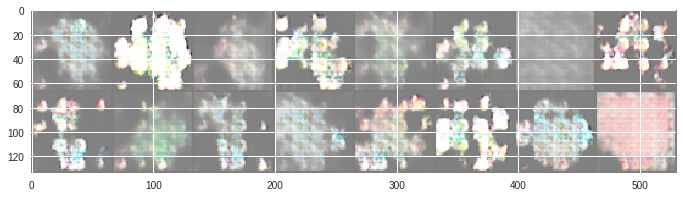

In [55]:
imshow(torchvision.utils.make_grid(fake.data.cpu()))

In [0]:
# do checkpointing
torch.save(G.state_dict(), 'netG_epoch_%d.pth' % epoch)
torch.save(D.state_dict(), 'netD_epoch_%d.pth' % epoch)

In [33]:
!ls


datalab				       netD_epoch_29.pth
Deep-Learning-Pokemon-Image-Generator  netG_epoch_29.pth




*   Exportar archivos
*   Tamaño imagenes mostradas
*   Cantidad de imagenes en la bd vs cantidad de epocas entrenado el modelo (Siraj usa apenas 200) - Telegram
*   Desactivar GPU y Guardar jupyer en local

